# Mid-circuit measurements with qiskit

This notebook will demonstrate how to do mid-circuit measurements and using the measurement results for future gates and measurements in qiskit. Since, one-way quantum computation (OWQC) essentially requires exactly all of those features we will use one-way implementation of simple quantum gates as examples. The two most relevant features which require mid-circuit measurements are:
1. Changing the basis of future measurements based on previous measurement results
2. Applying (Pauli-) operators to the finals output state based on previous measurement outcomes

Two very easy examples from OWQC, which already show both of the above features are the one-way implementation of a single-qubit z-rotation and a single-qubit x-rotation.
It seems appropriate to start with a z-rotation $R^z(\theta)$ first and then continue with a x-rotation $R^x(\theta)$.

The general single-qubit z-rotation $R^z(\theta)$ around an arbitrary angle $\theta$ as a one-way quantum computation is given by the following circuit:

![One-way implementation of a single-qubit z-rotation.](Rz_sqtp.png)

Here, only the second feature is required. Namely we have to apply the Pauli $X$ and $Z$ operators based on the previous measurement outcomes. As will be seen below this can be done via the if_test method of the qiskit QuantumCircuit objects.
Now, lets start to implement the shown circuit in qiskit and test the outcome.

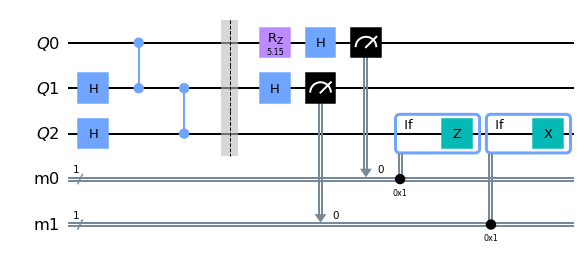

In [15]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution


# generate a random single qubit unitary to generate a random state in the first qubit
random_gate = UGate(
    theta=np.random.random() * 2 * np.pi,
    phi=np.random.random() * 2 * np.pi,
    lam=np.random.random() * 2 * np.pi,
)

# create the required qubits as QuantumRegisters
qubit_0 = QuantumRegister(1, "Q0")
qubit_1 = QuantumRegister(1, "Q1")
qubit_2 = QuantumRegister(1, "Q2")
# Each measurement gets a ClassicalRegister
m_0 = ClassicalRegister(1, "m0")
m_1 = ClassicalRegister(1, "m1")

circ_rz = QuantumCircuit(qubit_0, qubit_1, qubit_2, m_0, m_1)

# generate the required linear cluster state
circ_rz.h(qubit_1)
circ_rz.h(qubit_2)

circ_rz.cz(qubit_0, qubit_1)
circ_rz.cz(qubit_1, qubit_2)

circ_rz.barrier()

# define the angle theta of the implemented z-rotation randomly (between 0 and 2pi)
theta = np.random.random() * 2 * np.pi

# implement measurement of first qubit in rotated measurement basis {Rz(theta)H|0,1>} by rotating the qubit first and then measure in Z basis
circ_rz.rz(theta, qubit_0)
circ_rz.h(qubit_0)
circ_rz.measure(qubit_0,m_0)

# implement measurement of the second qubit in X basis
circ_rz.h(qubit_1)
circ_rz.measure(qubit_1, m_1)

# apply Pauli corrections X^m0 * Z^m1 to get the desired output state in the third  qubit
with circ_rz.if_test((m_0, 1)):
    circ_rz.z(qubit_2)

with circ_rz.if_test((m_1, 1)):
    circ_rz.x(qubit_2)

# show final rz circuit
display(circ_rz.draw(output='mpl'))


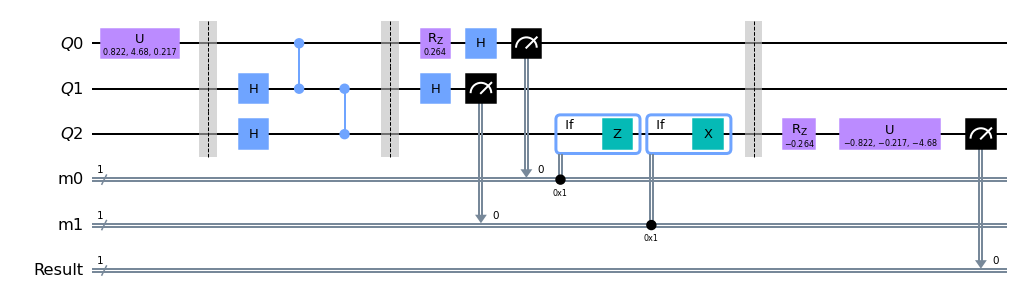

In [9]:

# To test the implementation we generate a new test circuit
test = QuantumCircuit(qubit_0, qubit_1, qubit_2, m_0, m_1)

# initialize the first qubit in an random state 
test.append(random_gate, qubit_0)
test.barrier()

# append the z-rotation implementation
test = test.compose(circ_rz)
test.barrier()

# now apply the inverse z-rotation to the third qubit
test.rz(-theta, qubit_2)

# Finally, apply also the inverse random unitary 
test.append(random_gate.inverse(), qubit_2)

# create a new Classical register to measure the third qubit
result_clb = ClassicalRegister(1, "Result")
test.add_register(result_clb)
test.measure(qubit_2, result_clb)

display(test.draw(output='mpl'))


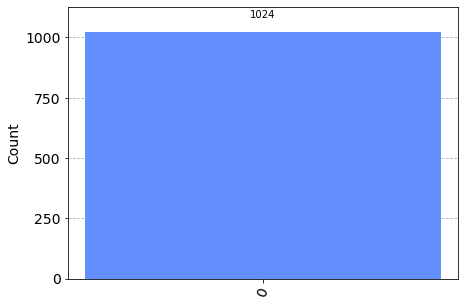

In [10]:
# run test circuit with aer simulator 
result = AerSimulator().run(test).result()
statistics = result.get_counts()
# filter the statistics to focus on the result bit. 
filtered_statistics = marginal_distribution(statistics, [2])
# The expected outcome should be "0" (initial state of qubit 0 before the random gate)
display(plot_histogram(filtered_statistics))

The general single-qubit x-rotation $R^x(\theta)$ around an arbitrary angle $\theta$ as a one-way quantum computation is given by the following circuit:

![One-way implementation of a single-qubit z-rotation.](Rx_sqtp.png)

Here, only both features are required. We have to again apply the Pauli $X$ and $Z$ operators based on the previous measurement outcomes to the output state but we also have to change the sign in the z-rotation on the second qubit based on the measurement result of the first qubit. As will be seen below both can be done via the if_test method of the qiskit QuantumCircuit objects.
Now, lets start to implement the shown circuit in qiskit and test the outcome.

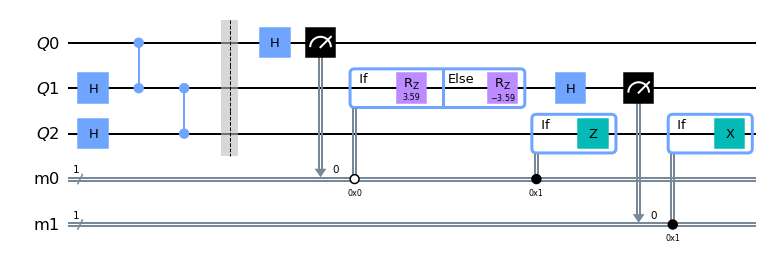

In [11]:

# generate a random single qubit unitary to generate a random state in the first qubit
random_gate = UGate(
    theta=np.random.random() * 2 * np.pi,
    phi=np.random.random() * 2 * np.pi,
    lam=np.random.random() * 2 * np.pi,
)

# create the required qubits as QuantumRegisters
qubit_0 = QuantumRegister(1, "Q0")
qubit_1 = QuantumRegister(1, "Q1")
qubit_2 = QuantumRegister(1, "Q2")
# Each measurement gets a ClassicalRegister
m_0 = ClassicalRegister(1, "m0")
m_1 = ClassicalRegister(1, "m1")

circ_rx = QuantumCircuit(qubit_0, qubit_1, qubit_2, m_0, m_1)

# generate the required linear cluster state
circ_rx.h(qubit_1)
circ_rx.h(qubit_2)

circ_rx.cz(qubit_0, qubit_1)
circ_rx.cz(qubit_1, qubit_2)

circ_rx.barrier()

# define the angle theta of the implemented z-rotation randomly (between 0 and 2pi)
theta = np.random.random() * 2 * np.pi

# implement measurement of the second qubit in X basis
circ_rx.h(qubit_0)
circ_rx.measure(qubit_0, m_0)

# implement measurement of first qubit in rotated measurement basis {Rz(theta)H|0,1>} by rotating the qubit first and then measure in Z basis
# decide what sign infront of angle theta is used based on previous measurement outcome
with circ_rx.if_test((m_0, 0)) as else_:
    circ_rx.rz(theta, qubit_1)
with else_:
    circ_rx.rz(-theta, qubit_1)
circ_rx.h(qubit_1)
circ_rx.measure(qubit_1,m_1)


# apply Pauli corrections X^m0 * Z^m1 to get the desired output state in the third  qubit
with circ_rx.if_test((m_0, 1)):
    circ_rx.z(qubit_2)

with circ_rx.if_test((m_1, 1)):
    circ_rx.x(qubit_2)

# show final rz circuit
display(circ_rx.draw(output='mpl'))


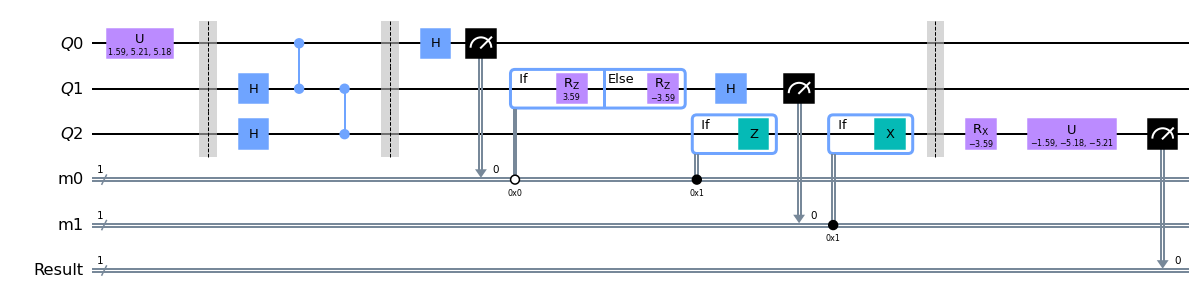

In [12]:

# To test the implementation we generate a new test circuit
test = QuantumCircuit(qubit_0, qubit_1, qubit_2, m_0, m_1)

# initialize the first qubit in an random state 
test.append(random_gate, qubit_0)
test.barrier()

# append the z-rotation implementation
test = test.compose(circ_rx)
test.barrier()

# now apply the inverse z-rotation to the third qubit
test.rx(-theta, qubit_2)

# Finally, apply also the inverse random unitary 
test.append(random_gate.inverse(), qubit_2)

# create a new Classical register to measure the third qubit
result_clb = ClassicalRegister(1, "Result")
test.add_register(result_clb)
test.measure(qubit_2, result_clb)

display(test.draw(output='mpl'))


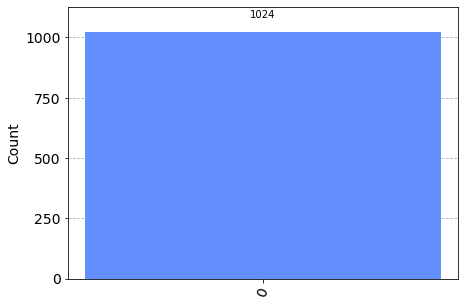

In [13]:
# run test circuit with aer simulator 
result = AerSimulator().run(test).result()
statistics = result.get_counts()
# filter the statistics to focus on the result bit. 
filtered_statistics = marginal_distribution(statistics, [2])
# The expected outcome should be "0" (initial state of qubit 0 before the random gate)
display(plot_histogram(filtered_statistics))

Another Qiskit Tutorial about that can be found [here](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action)